In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [8]:
# load data from database
conn = sqlite3.connect('../data/analysis.db')

df_monthly = pd.read_sql('SELECT * FROM monthly_analysis', conn)
print(f"Loaded {len(df_monthly):,} monthly analysis records")

df_air = pd.read_sql('SELECT * FROM air_quality LIMIT 10000', conn)
df_hosp = pd.read_sql('SELECT * FROM hospital_visits LIMIT 10000', conn)

print(f"Loaded {len(df_air):,} air quality records (sample)")
print(f"Loaded {len(df_hosp):,} hospital visit records (sample)")

df_monthly.head()

Loaded 555 monthly analysis records
Loaded 10,000 air quality records (sample)
Loaded 10,000 hospital visit records (sample)


,month,respiratory_category,avg_visit_percent,parameter,avg_pollution,record_count
0,2015-10,Broad Acute Respiratory,0.055516,PM2.5 - Local Conditions,7.562857,1
1,2015-10,COVID-19,0.000000,PM2.5 - Local Conditions,7.562857,1
2,2015-10,ILI,0.022966,PM2.5 - Local Conditions,7.562857,1
3,2015-10,Influenza,0.000645,PM2.5 - Local Conditions,7.562857,1
4,2015-10,RSV,0.000111,PM2.5 - Local Conditions,7.562857,1


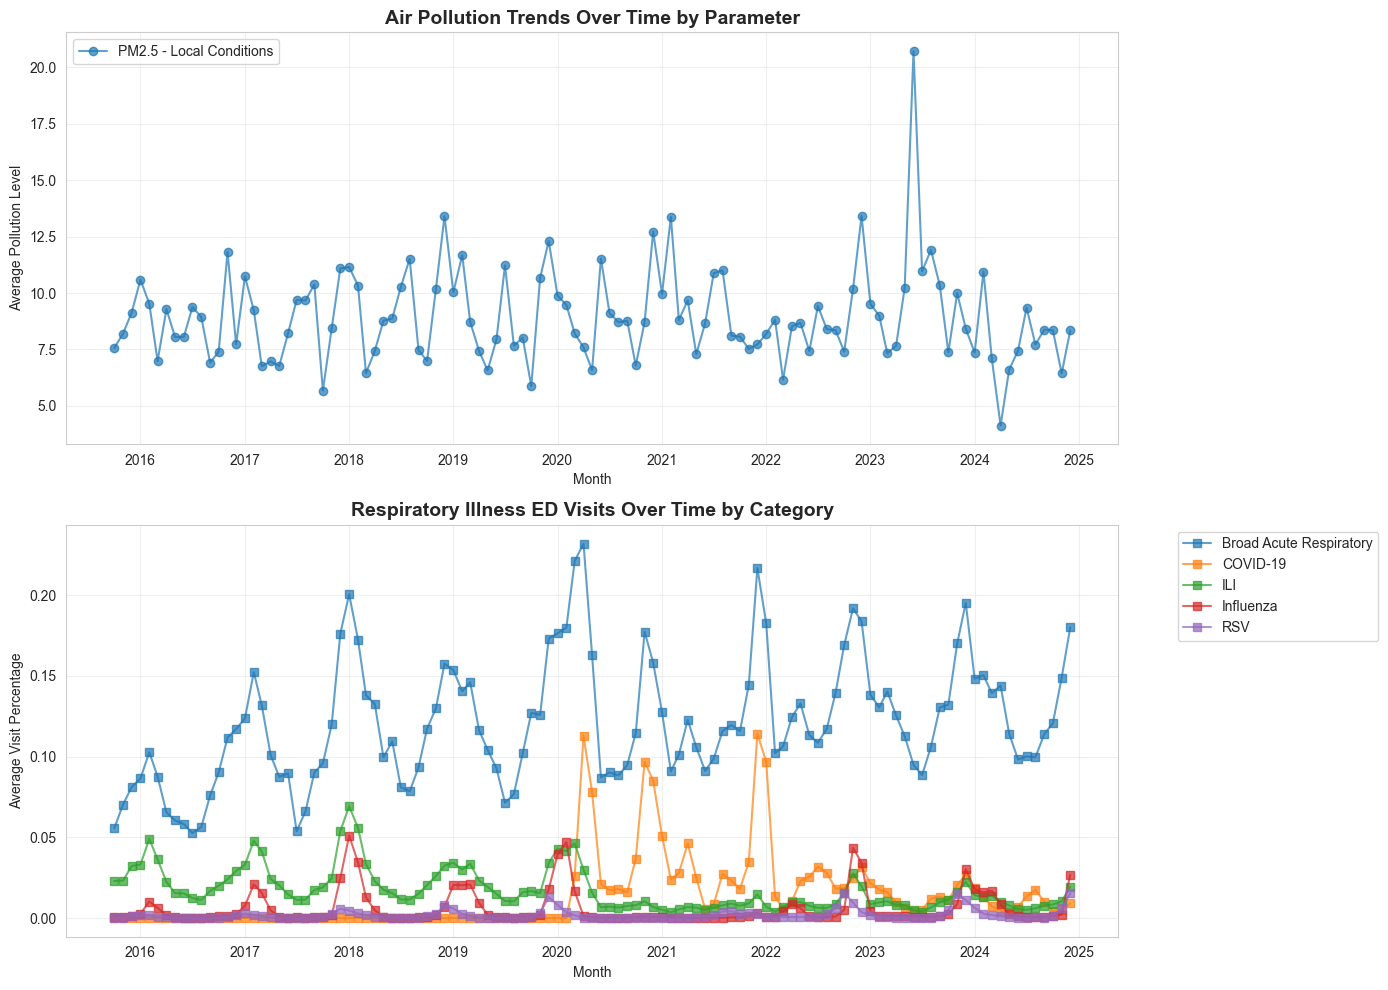

Time series plot saved to: ../data/timeseries_analysis.png


In [11]:
# time series visualization
df_monthly['month_dt'] = pd.to_datetime(df_monthly['month'])

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# plot 1: air pollution over time by parameter
for param in df_monthly['parameter'].unique():
    param_data = df_monthly[df_monthly['parameter'] == param]
    param_monthly = param_data.groupby('month_dt')['avg_pollution'].mean().reset_index()
    axes[0].plot(param_monthly['month_dt'], param_monthly['avg_pollution'], 
                 marker='o', label=param, alpha=0.7)

axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Pollution Level')
axes[0].set_title('Air Pollution Trends Over Time by Parameter', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# plot 2: respiratory visits over time by category
for category in df_monthly['respiratory_category'].unique()[:5]:
    cat_data = df_monthly[df_monthly['respiratory_category'] == category]
    cat_monthly = cat_data.groupby('month_dt')['avg_visit_percent'].mean().reset_index()
    axes[1].plot(cat_monthly['month_dt'], cat_monthly['avg_visit_percent'], 
                 marker='s', label=category, alpha=0.7)

axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Visit Percentage')
axes[1].set_title('Respiratory Illness ED Visits Over Time by Category', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/timeseries_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Time series plot saved to: ../data/timeseries_analysis.png")

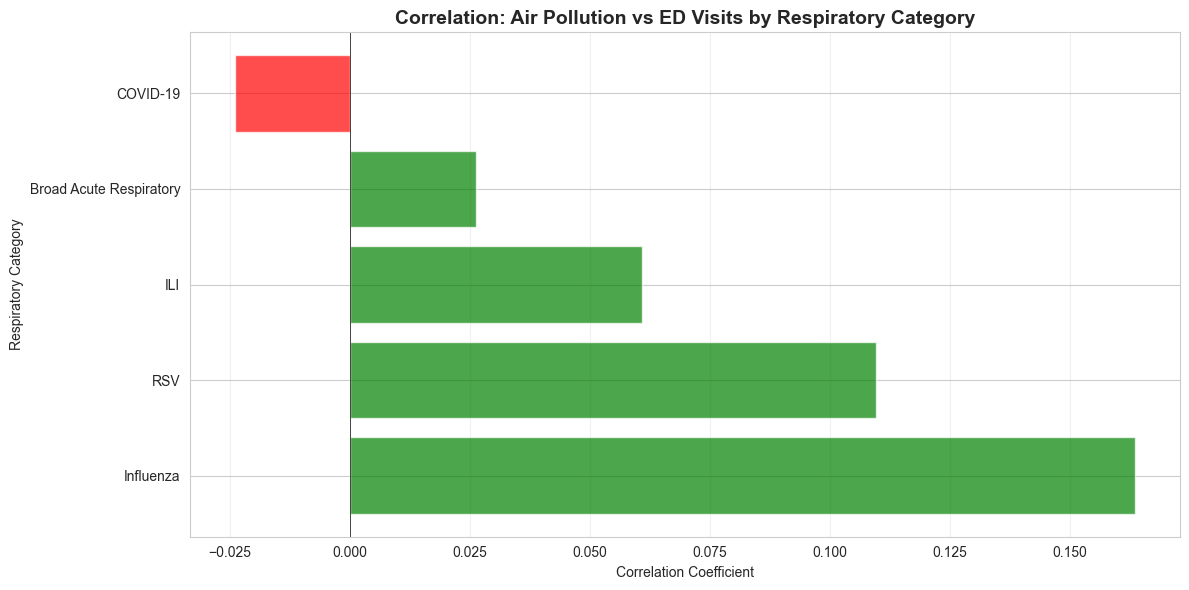

Correlation plot saved to: ../data/correlation_by_category.png

Correlation Results:
               category  correlation  n_records
              Influenza     0.163508        111
                    RSV     0.109546        111
                    ILI     0.060936        111
Broad Acute Respiratory     0.026365        111
               COVID-19    -0.023858        111


In [13]:
# correlation analysis
correlation_results = []

for category in df_monthly['respiratory_category'].unique():
    cat_df = df_monthly[df_monthly['respiratory_category'] == category]
    if len(cat_df) > 2:
        corr = cat_df[['avg_pollution', 'avg_visit_percent']].corr().iloc[0, 1]
        correlation_results.append({
            'category': category,
            'correlation': corr,
            'n_records': len(cat_df)
        })

corr_df = pd.DataFrame(correlation_results).sort_values('correlation', ascending=False)

# visualize correlations
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in corr_df['correlation']]
plt.barh(corr_df['category'], corr_df['correlation'], color=colors, alpha=0.7)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Respiratory Category')
plt.title('Correlation: Air Pollution vs ED Visits by Respiratory Category', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../data/correlation_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation plot saved to: ../data/correlation_by_category.png")
print("\nCorrelation Results:")
print(corr_df.to_string(index=False))

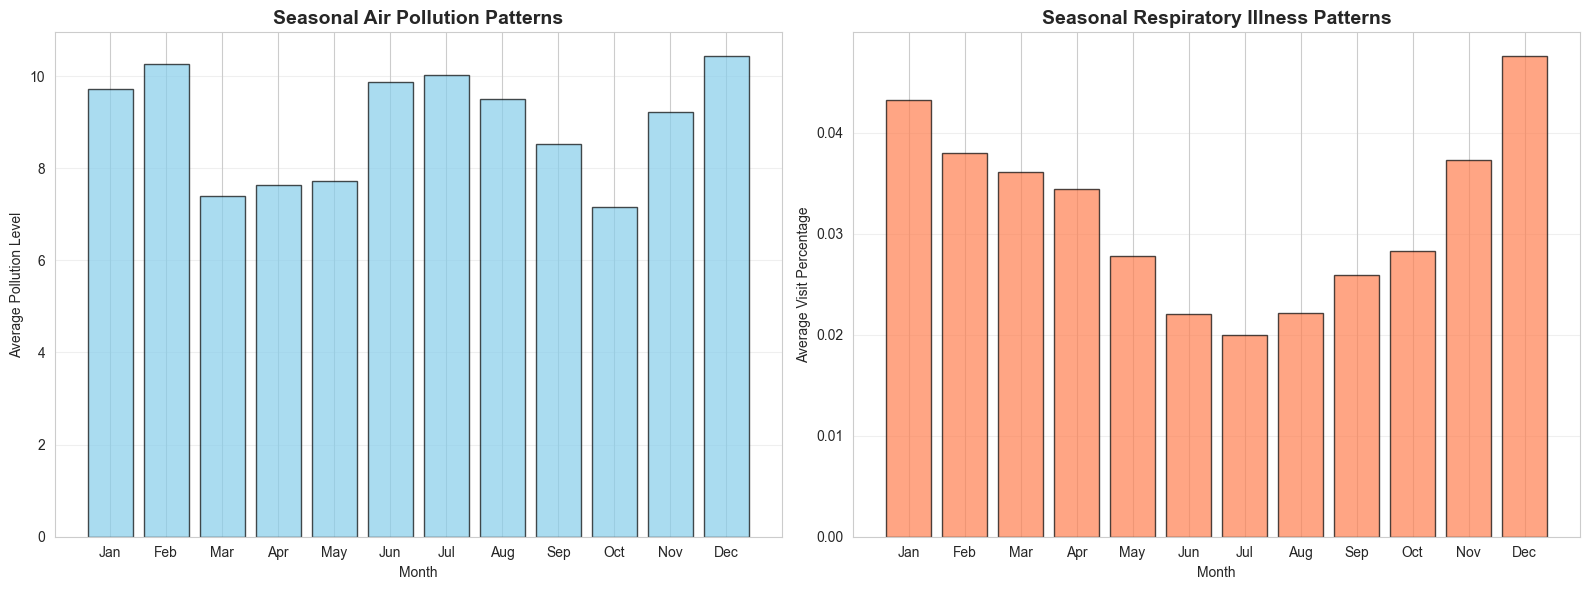

Seasonal pattern plot saved to: data/seasonal_patterns.png


In [14]:
# seasonal pattern analysis
df_monthly['month_num'] = df_monthly['month_dt'].dt.month
df_monthly['month_name'] = df_monthly['month_dt'].dt.strftime('%B')

seasonal = df_monthly.groupby('month_num').agg({
    'avg_pollution': 'mean',
    'avg_visit_percent': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# plot 1: seasonal pollution levels
axes[0].bar(seasonal['month_num'], seasonal['avg_pollution'], 
            color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Pollution Level')
axes[0].set_title('Seasonal Air Pollution Patterns', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_names)
axes[0].grid(True, alpha=0.3, axis='y')

# plot 2: seasonal respiratory visit rates
axes[1].bar(seasonal['month_num'], seasonal['avg_visit_percent'], 
            color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Visit Percentage')
axes[1].set_title('Seasonal Respiratory Illness Patterns', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("Seasonal pattern plot saved to: data/seasonal_patterns.png")

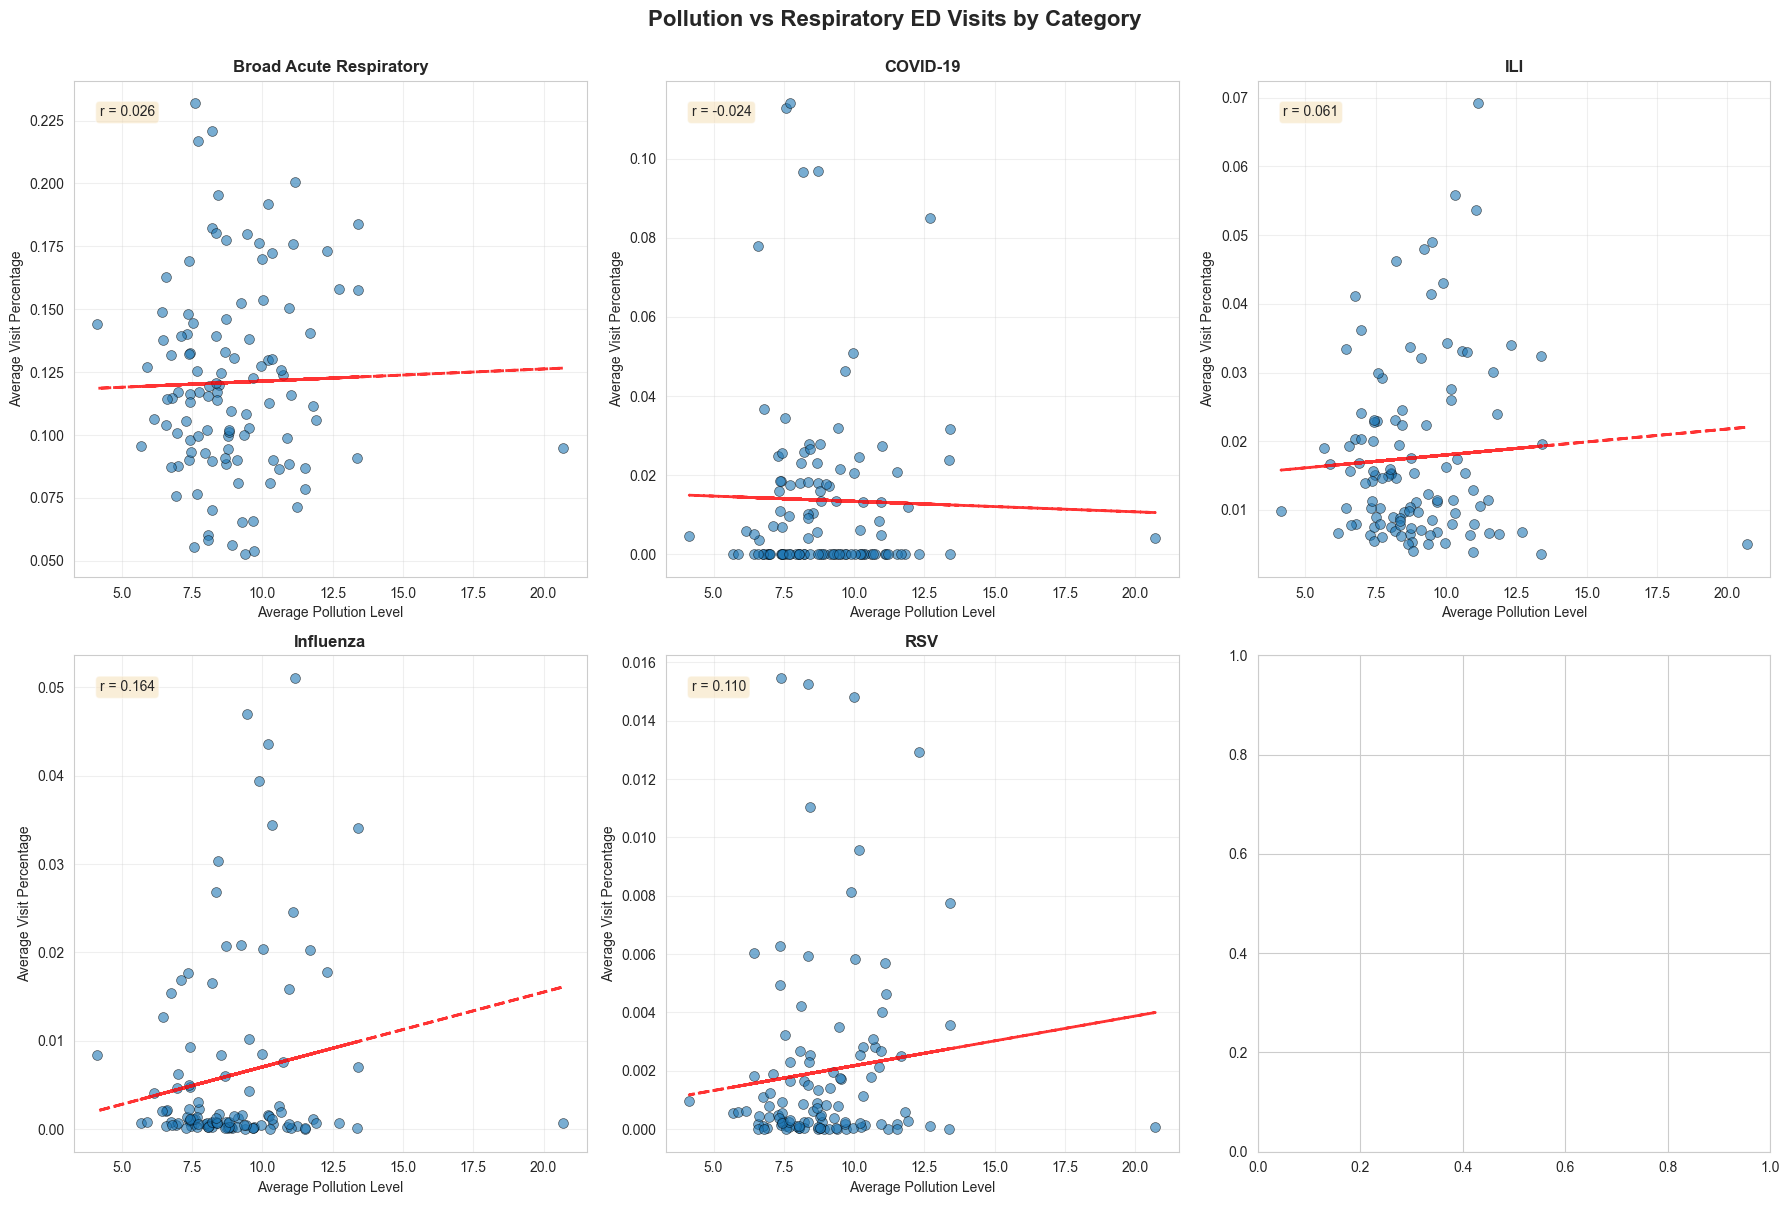

Scatter plot saved to: ../data/scatter_by_category.png


In [16]:
# scatter plots: pollution vs respiratory visits
categories = df_monthly['respiratory_category'].unique()[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, category in enumerate(categories):
    cat_data = df_monthly[df_monthly['respiratory_category'] == category]
    
    axes[idx].scatter(cat_data['avg_pollution'], cat_data['avg_visit_percent'], 
                      alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # add trend line
    if len(cat_data) > 2:
        z = np.polyfit(cat_data['avg_pollution'], cat_data['avg_visit_percent'], 1)
        p = np.poly1d(z)
        axes[idx].plot(cat_data['avg_pollution'], p(cat_data['avg_pollution']), 
                       "r--", alpha=0.8, linewidth=2)
        
        # calculate correlation
        corr = cat_data[['avg_pollution', 'avg_visit_percent']].corr().iloc[0, 1]
        axes[idx].text(0.05, 0.95, f'r = {corr:.3f}', 
                       transform=axes[idx].transAxes, 
                       fontsize=10, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    axes[idx].set_xlabel('Average Pollution Level')
    axes[idx].set_ylabel('Average Visit Percentage')
    axes[idx].set_title(category, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Pollution vs Respiratory ED Visits by Category', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../data/scatter_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

print("Scatter plot saved to: ../data/scatter_by_category.png")

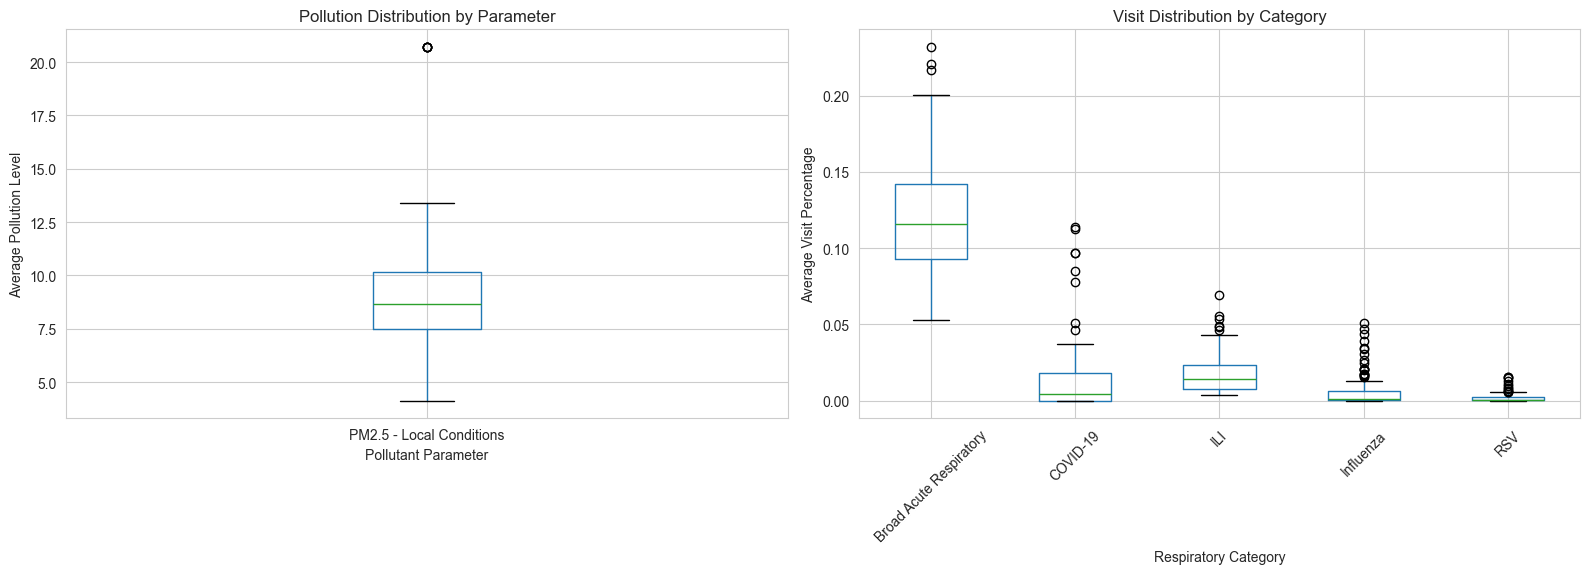

Box plot saved to: ../data/distribution_boxplots.png


In [18]:
# box plots: distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# box plot 1: pollution by parameter
df_monthly.boxplot(column='avg_pollution', by='parameter', ax=axes[0])
axes[0].set_xlabel('Pollutant Parameter')
axes[0].set_ylabel('Average Pollution Level')
axes[0].set_title('Pollution Distribution by Parameter')
axes[0].get_figure().suptitle('')

# box plot 2: visit percentage by respiratory category
top_categories = df_monthly['respiratory_category'].value_counts().head(6).index
df_top = df_monthly[df_monthly['respiratory_category'].isin(top_categories)]
df_top.boxplot(column='avg_visit_percent', by='respiratory_category', ax=axes[1])
axes[1].set_xlabel('Respiratory Category')
axes[1].set_ylabel('Average Visit Percentage')
axes[1].set_title('Visit Distribution by Category')
axes[1].get_figure().suptitle('')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../data/distribution_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Box plot saved to: ../data/distribution_boxplots.png")

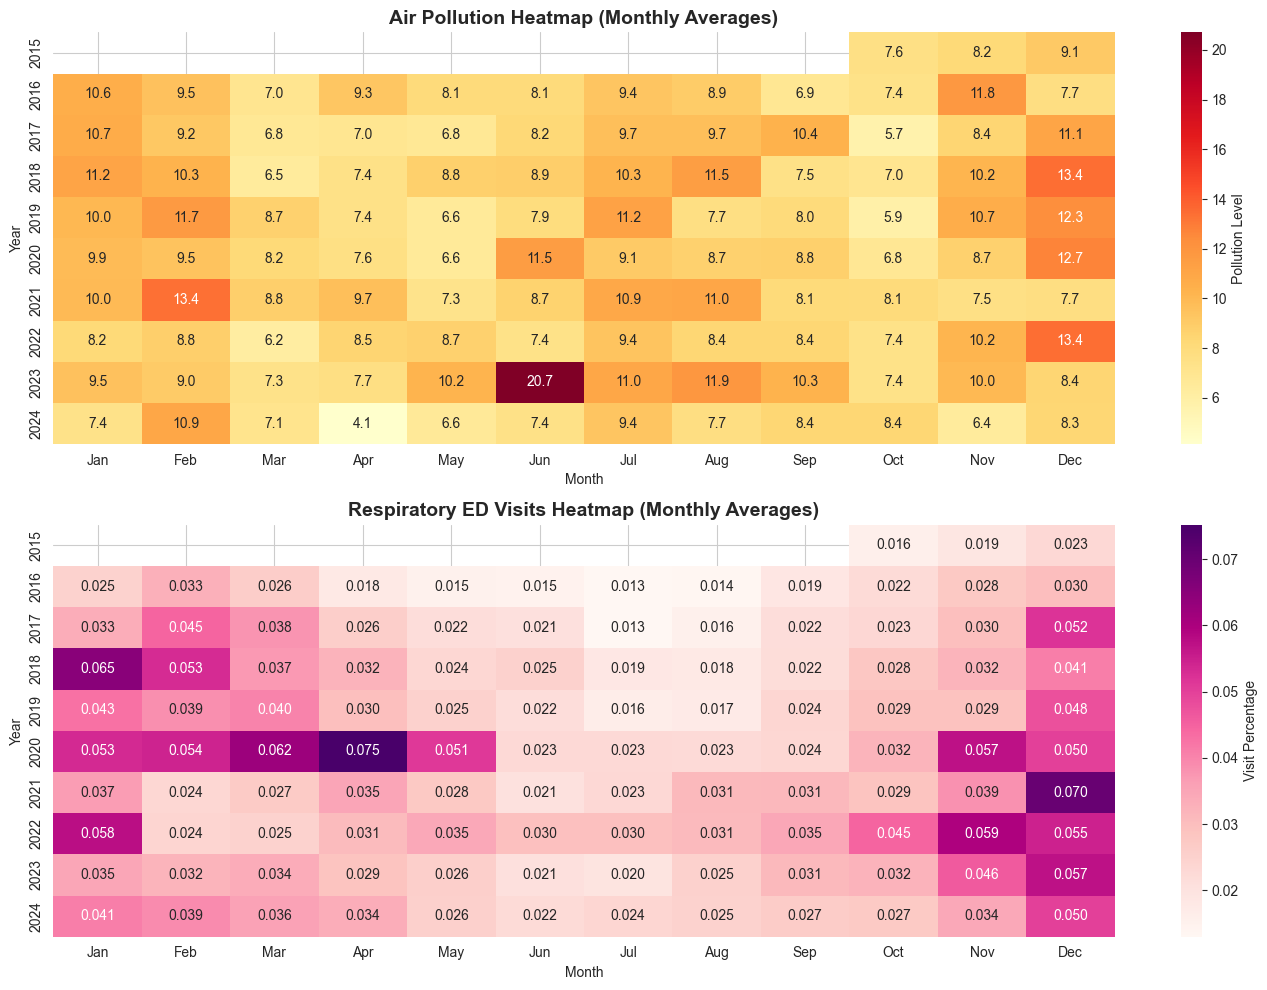

Heatmap saved to: ../data/monthly_heatmaps.png


In [19]:
# heatmap: monthly patterns
df_monthly['year'] = df_monthly['month_dt'].dt.year

# aggregate by year and month
pivot_pollution = df_monthly.groupby(['year', 'month_num'])['avg_pollution'].mean().reset_index()
pivot_visits = df_monthly.groupby(['year', 'month_num'])['avg_visit_percent'].mean().reset_index()

# create pivot tables
heatmap_pollution = pivot_pollution.pivot(index='year', columns='month_num', values='avg_pollution')
heatmap_visits = pivot_visits.pivot(index='year', columns='month_num', values='avg_visit_percent')

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# heatmap 1: pollution levels
sns.heatmap(heatmap_pollution, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Pollution Level'}, ax=axes[0])
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Year')
axes[0].set_title('Air Pollution Heatmap (Monthly Averages)', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(month_names)

# heatmap 2: visit percentages
sns.heatmap(heatmap_visits, annot=True, fmt='.3f', cmap='RdPu', 
            cbar_kws={'label': 'Visit Percentage'}, ax=axes[1])
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Year')
axes[1].set_title('Respiratory ED Visits Heatmap (Monthly Averages)', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(month_names)

plt.tight_layout()
plt.savefig('../data/monthly_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("Heatmap saved to: ../data/monthly_heatmaps.png")

In [20]:
# summary statistics
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\nPollution Statistics:")
print("-"*80)
print(df_monthly['avg_pollution'].describe())

print("\nRespiratory Visit Statistics:")
print("-"*80)
print(df_monthly['avg_visit_percent'].describe())

print("\nBy Respiratory Category:")
print("-"*80)
category_summary = df_monthly.groupby('respiratory_category').agg({
    'avg_visit_percent': ['mean', 'std', 'min', 'max', 'count']
}).round(4)
print(category_summary)

print("\nBy Pollutant Parameter:")
print("-"*80)
param_summary = df_monthly.groupby('parameter').agg({
    'avg_pollution': ['mean', 'std', 'min', 'max', 'count']
}).round(2)
print(param_summary)

print("\n" + "="*80)

conn.close()
print("\nAll visualizations completed")

SUMMARY STATISTICS

Pollution Statistics:
--------------------------------------------------------------------------------
count    555.000000
mean       8.954937
std        2.088375
min        4.136667
25%        7.477143
50%        8.676667
75%       10.183333
max       20.706897
Name: avg_pollution, dtype: float64

Respiratory Visit Statistics:
--------------------------------------------------------------------------------
count    555.000000
mean       0.032076
std        0.049684
min        0.000000
25%        0.000565
50%        0.007589
75%        0.033835
max        0.231934
Name: avg_visit_percent, dtype: float64

By Respiratory Category:
--------------------------------------------------------------------------------
                        avg_visit_percent                              
                                     mean     std     min     max count
respiratory_category                                                   
Broad Acute Respiratory            0.1209  0.0